In [318]:
# simple encoding without image compression 

import torch
import io
import json #dosent serialize bytes
import msgpack

def tensor_to_bytes(tensor):
    """Convert a PyTorch tensor to bytes."""
    buffer = io.BytesIO()
    torch.save(tensor, buffer)
    return buffer.getvalue()

def bytes_to_tensor(tensor_bytes):
    """Convert bytes back to a PyTorch tensor."""
    buffer = io.BytesIO(tensor_bytes)
    return torch.load(buffer)


def dict_to_bytes(data_dict):
    return msgpack.packb(data_dict, use_bin_type=True)


def bytes_to_dict(json_str):
    return msgpack.unpackb(json_str, raw=False)

# Create a sample tensor

original_tensor = torch.randint(low=0, high=255, size=(448, 896, 3), dtype=torch.uint8)
# print("Original Tensor:")
# print(original_tensor)

# Encode the tensor to bytes
encoded_tensor = tensor_to_bytes(original_tensor)

data = {'image' : encoded_tensor, 'image_id' : 0}
enc_data  = dict_to_bytes(data) 
dec_data = bytes_to_dict(enc_data)
print(f'encoded json with bytes size {len(enc_data)/1e6}')

decoded_tensor = bytes_to_tensor(dec_data['image'])

is_equal = torch.all(original_tensor.eq(decoded_tensor))
print("\nOriginal and decoded compressed tensors using are identical:", is_equal.item())






encoded json with compress tensor bytes size 1.205426

Original and decoded compressed tensors using are identical: True


torch.Size([3, 448, 896]) torch.float32 tensor(0.0196) tensor(0.9961)


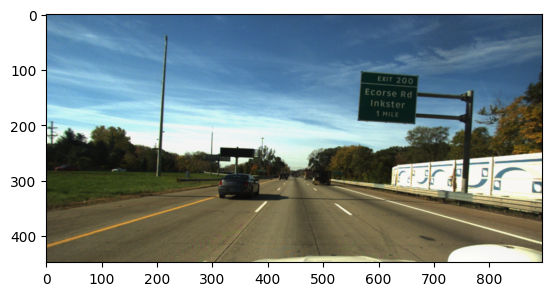

encoded json with compressed image bytes size 0.085129


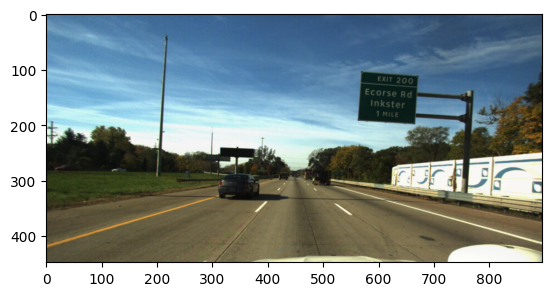

torch.Size([3, 448, 896]) torch.float32 tensor(0.) tensor(1.)


In [356]:
# encoding with compressing the image using jpeg encoding 

import torch 
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from torch.utils.data import DataLoader
import simplejpeg
from matplotlib import pyplot as plt

logs_start = 0; logs_end = 5
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress
train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], mode='train')

data_id = 1800
data  = train_set[data_id]

print(data[1][0].shape, data[1][0].dtype, data[1][0].min(), data[1][0].max())

grd_img_numpy = data[1][0] * 255 
grd_img_numpy = torch.permute(grd_img_numpy, (1,2,0)).contiguous()
grd_img_numpy = grd_img_numpy.to(torch.uint8).numpy()


plt.imshow(grd_img_numpy)
plt.show()


grd_img_bytes = simplejpeg.encode_jpeg(grd_img_numpy)
data = {'image': grd_img_bytes, 'image_id':data_id}

enc_data  = dict_to_bytes(data) 

print(f'encoded json with compressed image bytes size {len(enc_data)/1e6}')

dec_data = bytes_to_dict(enc_data)
grd_img_numpy = simplejpeg.decode_jpeg(dec_data['image'])
plt.imshow(grd_img_numpy)
plt.show()


grd_img_torch = torch.tensor(grd_img_numpy, dtype=torch.float32) / 255.0
grd_img_torch = torch.permute(grd_img_torch, [2,0,1]).contiguous()
print(grd_img_torch.size(), grd_img_torch.dtype, grd_img_torch.min(), grd_img_torch.max())

